In [ ]:
文章参考: https://blog.csdn.net/youcans/article/details/124005009

本文介绍了图像分割的基本概念，强调了图像分割在计算机视觉中的重要性。点、线和边缘检测是基于图像灰度不连续性的图像分割方法。文章详细讲解了孤立点检测，利用拉普拉斯算子通过二阶导数检测图像中的孤立点，并给出了Python代码示例。此外，还探讨了不同类型的图像分割方法和技术。

# 图像分割基本概念

图像分割就是把图像分成若干个特定的、具有独特性质的区域并提出感兴趣目标的技术和过程。图像分割是由图像处理到图像分析的关键步骤，是计算机视觉的基础，也是图像理解的重要组成部分。

所谓图像分割是指根据灰度、彩色、空间纹理、几何形状等特征把图像划分成若干个互不相交的区域，使得这些特征在同一区域内表现出一致性或相似性，而在不同区域间表现出明显的不同。简单的说就是在一副图像中，把目标从背景中分离出来。

从数学角度来看，图像分割是将数字图像划分成互不相交的区域的过程。图像分割的过程也是一个标记过程，即把属于同一区域的像索赋予相同的编号。

图像分割的基本方法是基于图像灰度值的不连续性和相似性。基于不连续性的图像分割，是根据灰度的突变检测边界，将图像分割为多个区域；基于相似性的图像分割，是根据预定义的准则将图像分割为多个相似的区域。

常用的图像分割方法有：基于阈值的分割方法、基于区域的分割方法、基于边缘的分割方法以及基于特定理论的分割方法等。

# 点、线和边缘检测

本节基于图像灰度的不连续性，讨论根据灰度的突变检测边界，以此为基础进行图像分割。

- 边缘像素是图像中灰度突变的像素，而边缘是相连边缘像素的集合。
- 线是一条细边缘线段，其两侧的背景灰度与线段的像素灰度存在显著差异。
- 孤立的点是一个被背景像素围绕的前景像素，或一个被前景像素围绕的背景像素。

导数可以用来检测灰度的局部突变：

- 一阶导数通常产生粗边缘；
- 二阶导数对精细细节（如细线、孤立点和噪声）的响应更强；
- 二阶导数在灰度斜坡和台阶过渡处会产生双边缘响应，即二阶导数在进入和离开边缘时的符号相反；
- 二阶导数的符号可用于确定边缘的过渡是从亮到暗还是从暗到亮。


计算图像中每个像素位置的一阶导数和二阶导数的方法是空间卷积。对一个 3*3 模板，计算模板区域内灰度值与模板系数的卷积。

## 图像的孤立点检测

孤立点的检测，是检测嵌在一幅图像的恒定区域或亮度几乎不变的区域里的孤立点。孤立点的检测以二阶导数为基础。

二阶导数的计算可以采用拉普拉斯二阶有限差分公式：

![image.png](./images/二阶导数.jpg)


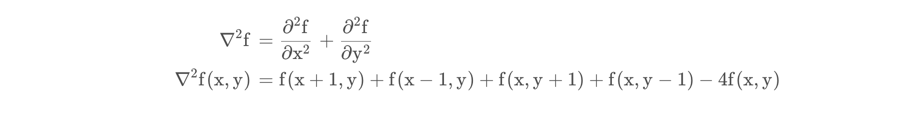

拉普拉斯差分公式可以用拉普拉斯核的卷积来实现：


![image.png](./images/拉普拉斯核.jpg)

当孤立点在卷积模板的中心时，拉普拉斯滤波器的响应很强烈，而孤立点在非模板中心时，拉普拉斯滤波器响应为零。当滤波器在一个点的响应超过设定阈值 T，则认为在卷积核的中心检测到了孤立点，标记为 1，而其它点都被标记为 0，从而产生一副二值图像。


![image.png](./images/二值图像.jpg)

注意：

（1）本节所称的孤立点检测，是绝对意义上的孤立点，即一个孤立的像素。人眼所能感知、识别的孤立点，通常来说其实是一个微小的区域，而不是孤立的一个像素，因此并不能用这种方法检测。

（2）使用 Laplace 算子进行图像孤立点检测，推荐使用 scipy.signal 实现卷积运算，不建议使用 cv2.filter2D 实现。后者自动将卷积结果进行归一化处理，不便于通过阈值 T 检测孤立点。


# 图像的孤立点检测

In [ ]:
    # 11.1 图像孤立点检测 (Laplace 算子)
    imgGray = cv2.imread("../images/lena_gray.bmp", flags=0)
    hImg, wImg = imgGray.shape

    # scipy.signal 实现卷积运算 (注意：不能用 cv2.filter2D 处理)
    from scipy import signal
    kernelLaplace = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])  # Laplacian kernel
    imgLaplace = signal.convolve2d(imgGray, kernelLaplace, boundary='symm', mode='same')  # same 卷积

    # 在原图上用半径为 5 的圆圈标记角点
    T = 0.9 * max(imgLaplace.max(), -imgLaplace.min())
    imgPoint = np.zeros((hImg, wImg), np.uint8)  # 创建黑色图像
    for h in range(hImg):
        for w in range(wImg):
            if (imgLaplace[h, w] > T) or (imgLaplace[h, w] < -T):
                imgPoint[h, w] = 255  # 二值处理
                cv2.circle(imgPoint, (w, h), 10, 255)

    print(imgLaplace.shape, imgLaplace.max(), imgLaplace.min(), T)
    plt.figure(figsize=(9, 6))
    plt.subplot(131), plt.axis('off'), plt.title("Original")
    plt.imshow(imgGray, cmap='gray', vmin=0, vmax=255)
    plt.subplot(132), plt.axis('off'), plt.title("Laplacian K2")
    plt.imshow(imgLaplace, cmap='gray', vmin=0, vmax=255)
    plt.subplot(133), plt.axis('off'), plt.title("Isolated point")
    plt.imshow(imgPoint, cmap='gray', vmin=0, vmax=255)
    plt.tight_layout()
    plt.show()
